# Stock price prediction

Predict company closing stock price using LSTM model, based on the sotck price of th 60 previous days.

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf

### 1) Data preparation

Fetch stock price data for a given company (use-case Apple)

In [2]:
start_date = '1970-01-01'
end_date = date.today().strftime("%Y-%m-%d")
company_code = 'AAL' #American Airlines

In [3]:
df = yf.download(tickers = company_code, start = start_date, end = end_date)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-09-27,21.049999,21.400000,19.100000,19.299999,18.194908,961200
2005-09-28,19.299999,20.530001,19.200001,20.500000,19.326199,5747900
2005-09-29,20.400000,20.580000,20.100000,20.209999,19.052803,1078200
2005-09-30,20.260000,21.049999,20.180000,21.010000,19.806999,3123300
2005-10-03,20.900000,21.750000,20.900000,21.500000,20.268946,1057900
...,...,...,...,...,...,...
2023-12-20,14.200000,14.390000,13.950000,13.980000,13.980000,26557500
2023-12-21,14.210000,14.430000,14.200000,14.350000,14.350000,30372600
2023-12-22,14.380000,14.400000,14.210000,14.310000,14.310000,25169900


Closing price history visualization

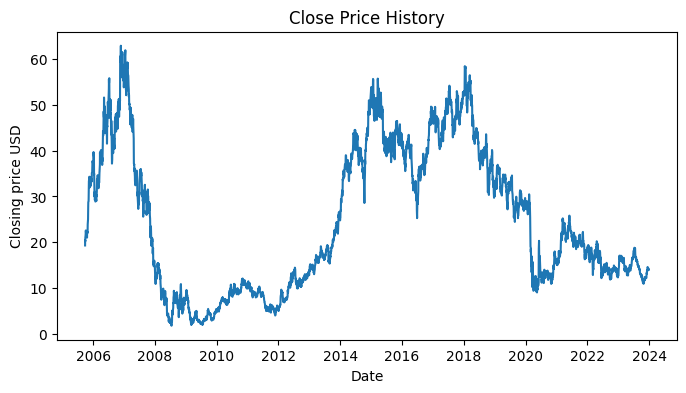

In [4]:
plt.figure(figsize=(8,4))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing price USD')
plt.show()

Split training / testing data

In [5]:
data = df['Close']
dataset = data.values #df to numpy array
len(dataset)

4594

In [7]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))
train_data = dataset[:training_data_len]
test_data = dataset[training_data_len:]

Normalize data

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_data.reshape(-1,1)).reshape(-1)
test_data = scaler.fit_transform(test_data.reshape(-1,1)).reshape(-1)

In [9]:
# Used for visualization and test purposes
standardized_train_test_data = np.concatenate([train_data,test_data],axis=0)

In [10]:
# plt.figure(figsize=(8,4))
# plt.title('Close Price History')
# plt.plot(df.index[:training_data_len], train_data)
# plt.xlabel('Date')
# plt.ylabel('Closing price USD')
# plt.show()

### 2) Next day closing stock price prediction via averaging

Predict closing stock price one day in advance using moving average

In [11]:
window_size = 100 # size of data window used to make predictions (nb of days)

#### 2.1) Standard average

Use the arithmetic average of prices of the previous days to predict the price for the next day

In [12]:
# Predict prices on known values of previous days
standard_avg_preds = []
standard_avg_x = []
standard_avg_mse = []
for i in range(window_size, training_data_len):
  prediction = np.mean( train_data[i-window_size:i] )
  standard_avg_preds.append(prediction)
  standard_avg_mse.append( (prediction - train_data[i])**2 )
  standard_avg_x.append(df.index[i])

print('MSE error for standard averaging: %.5f'%(np.mean(standard_avg_mse)))

MSE error for standard averaging: 0.00626


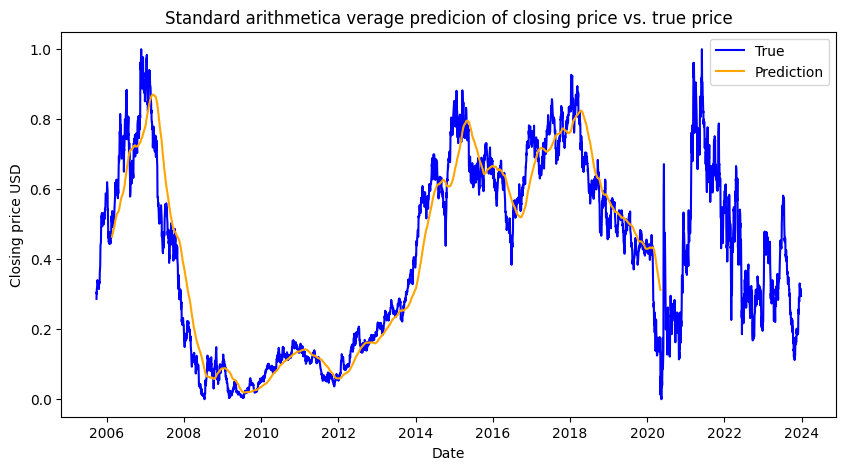

In [13]:
plt.figure(figsize = (10,5))
plt.plot(df.index, standardized_train_test_data, color='b', label='True')
plt.plot(standard_avg_x, standard_avg_preds, color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Closing price USD')
plt.title("Standard arithmetica verage predicion of closing price vs. true price")
plt.legend()
plt.show()

#### 2.2) Exponential moving average

Using exponential moving average: $x_{t+1} = EMA_{t} = \gamma \times EMA_{t-1} + (1-\gamma) x_t$, where:
- $EMA_0 = 0$
- $\gamma$ sets the contribution of the most recent prediction is to the EMA

In [14]:
run_avg_preds = []
run_avg_x = []
run_avg_mse = []
decay = 0.5
running_mean = 0.0
for i in range(1,training_data_len):
    running_mean = running_mean*decay + (1.0-decay)*train_data[i-1]
    run_avg_preds.append(running_mean)
    run_avg_mse.append( (running_mean - train_data[i])**2 )
    run_avg_x.append(df.index[i])
print('MSE error for EMA averaging: %.5f'%(np.mean(run_avg_mse)))

MSE error for EMA averaging: 0.00027


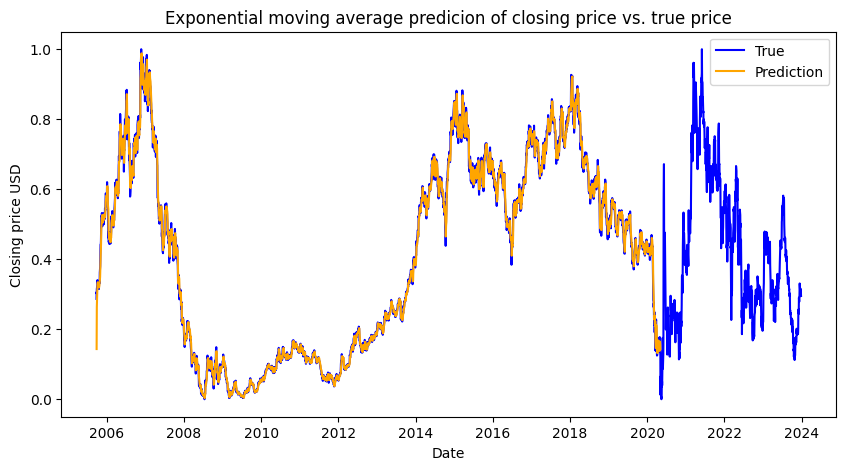

In [15]:
plt.figure(figsize = (10,5))
plt.plot(df.index, standardized_train_test_data, color='b', label='True')
plt.plot(run_avg_x, run_avg_preds, color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Closing price USD')
plt.title("Exponential moving average predicion of closing price vs. true price")
plt.legend()
plt.show()

### 3) Prediction of future movements in closing stock prices via LSTM (multiple day trends)

Create traing data batch

In [16]:

# Source: https://www.datacamp.com/tutorial/lstm-python-stock-market
class DataGeneratorSeq(object):
    
    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size #size of each batch
        self._num_unroll = num_unroll #nb of batch
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))


dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.28664812 0.08694231 0.07223402 0.69030887 0.76777256]

	Output: [0.31459388 0.10459225 0.06896552 0.65680665 0.76237947]


Unrolled index 1
	Inputs:  [0.30625919 0.10459225 0.06896552 0.6733126  0.7550253 ]

	Output: [0.32260174 0.10998528 0.06144795 0.6514136  0.7550253 ]


Unrolled index 2
	Inputs:  [0.30151984 0.10998528 0.07321458 0.68802094 0.76237947]

	Output: [0.31459388 0.11537832 0.07321458 0.6514136  0.7841151 ]


Unrolled index 3
	Inputs:  [0.31459388 0.11537832 0.06863867 0.65680665 0.77283865]

	Output: [0.31459388 0.10050662 0.06765811 0.6265729  0.7841151 ]


Unrolled index 4
	Inputs:  [0.32260174 0.11080242 0.06144795 0.6514136  0.78051966]

	Output: [0.3340415  0.11080242 0.06144795 0.6574604  0.7841151 ]


In [25]:
u_data

[array([0.28664812, 0.08694231, 0.07223402, 0.69030887, 0.76777256],
       dtype=float32),
 array([0.30625919, 0.10459225, 0.06896552, 0.6733126 , 0.7550253 ],
       dtype=float32),
 array([0.30151984, 0.10998528, 0.07321458, 0.68802094, 0.76237947],
       dtype=float32),
 array([0.31459388, 0.11537832, 0.06863867, 0.65680665, 0.77283865],
       dtype=float32),
 array([0.32260174, 0.11080242, 0.06144795, 0.6514136 , 0.78051966],
       dtype=float32)]

In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (u_data.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(u_data, u_labels, batch_size=1, epochs=1)

ValueError: in user code:

    File "c:\Users\Amine\anaconda3\envs\TensorflowKerasEnv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Amine\anaconda3\envs\TensorflowKerasEnv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Amine\anaconda3\envs\TensorflowKerasEnv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Amine\anaconda3\envs\TensorflowKerasEnv\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Amine\anaconda3\envs\TensorflowKerasEnv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Amine\anaconda3\envs\TensorflowKerasEnv\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential_1" expects 1 input(s), but it received 5 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(1,) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(1,) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(1,) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(1,) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(1,) dtype=float32>]


In [17]:
import tensorflow as tf
# import tensorflow.compat.v1 as tf1
# tf1.disable_v2_behavior() 

In [18]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf1.reset_default_graph() # This is important in case you run this multiple times

NameError: name 'tf1' is not defined

In [19]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf1.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf1.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


NameError: name 'tf1' is not defined

In [20]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))


AttributeError: module 'tensorflow' has no attribute 'contrib'